In [2]:
import openai as openai
import os
import json
from tqdm import tqdm
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel

api_key = ''
with open('../../openai.txt', 'r') as file:
    api_key = file.read().replace('\n', '')

client = openai.OpenAI(api_key=api_key)

In [2]:
def list_models():
    """
    List all available models in the OpenAI API.
    """
    models = client.models.list()
    print("Available models:")

    model_ids = []
    for model in models.data:
        model_ids.append(model.id)

    model_ids.sort()
    for model_id in model_ids:
        print(model_id)

# list_models(client)

In [3]:
def costs(prompt_tokens, completion_tokens):
    """
    Calculate the costs based on the number of tokens used.
    Args:
        prompt_tokens (int): The number of prompt tokens used.
        completion_tokens (int): The number of completion tokens used.
    Returns:
        float: The total cost in dollars.
    """
    if model_used == 'gpt-4o-mini':
        price_per_1m_input_tokens = 0.15
        price_per_1m_output_tokens = 0.6
    elif model_used == 'gpt-4o':
        price_per_1m_input_tokens = 2.5
        price_per_1m_output_tokens = 10
    elif model_used == 'o4-mini':
        price_per_1m_input_tokens = 1.10
        price_per_1m_output_tokens = 4.40
    else:
        raise ValueError(
            "Model not set or not supported for cost calculation.")
    total_cost = ((prompt_tokens / 1000000) * price_per_1m_input_tokens) + \
        ((completion_tokens / 1000000) * price_per_1m_output_tokens)
    return total_cost

In [ ]:
class StructuredResponse(BaseModel):
    difference: int
    explanation: str


def llm_call(prompt):
    """
    Call the OpenAI API to get a response based on the provided system and user prompts.
    Args:
        prompt (str): The prompt to send to the OpenAI API.
    Returns:
        tuple: A tuple containing the answer, prompt tokens, completion tokens, and total tokens.
    """
    global global_prompt_tokens, global_completion_tokens

    retries = 0
    max_completion_tokens = 2000
    while True:
        try:
            response = client.beta.chat.completions.parse(
                model=model_used,
                messages=[
                    {"role": "system", "content": prompt}
                ],
                max_completion_tokens=max_completion_tokens,
                response_format=StructuredResponse
            )
            break
        except openai.LengthFinishReasonError as e:
            # Retry with larger max_completion_tokens
            max_completion_tokens *= 2

            prompt_tokens += e.completion.usage.prompt_tokens
            completion_tokens += e.completion.usage.completion_tokens
            total_tokens += e.completion.usage.total_tokens

            global_prompt_tokens += e.completion.usage.prompt_tokens
            global_completion_tokens += e.completion.usage.completion_tokens
        except Exception as e:
            retries += 1
            backoff_time = (2 ** retries) + random.random()
            print(f"Retrying in {backoff_time:.2f} seconds...")
            time.sleep(backoff_time)

    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens

    global_prompt_tokens += response.usage.prompt_tokens
    global_completion_tokens += response.usage.completion_tokens

    answer = response.choices[0].message.parsed.model_dump()

    # Uncomment the following lines to simulate a mock response
    # answer = {
    #     "difference": random.choice([-2, -1, 1, 2]),
    #     "explanation": "This is a mock response."
    # }
    # prompt_tokens = 100
    # completion_tokens = 200
    # total_tokens = prompt_tokens + completion_tokens

    # global_prompt_tokens += prompt_tokens
    # global_completion_tokens += completion_tokens

    return answer, prompt_tokens, completion_tokens, total_tokens

In [5]:
def comparison(first, second, topic, concepts, criteria, c_question, iterations, number, student_level, materials):
    prompt = f"""
    You are an expert teacher in the field of reflection questions. Your task is to evaluate two responses containing a single reflective question based on given criteria. Not all key concepts need to be present in the question.
    
    The topic is {topic}.
    The key concepts are {concepts}
    The criteria is {criteria}: {c_question}
    
    Provide a difference score from list [-2, -1, 1, 2]. The more negative the score, the better is the first question over the second. The more positive the score, the better is the second question over the first. Then provide a brief explanation of the chosen difference (at most 2 sentences).

    Question 1: 
    {first}
    Question 2: 
    {second}
    """

    answer, pt, ct, tt = llm_call(prompt)

    return {
        "first": first,
        "second": second,
        "attempt": number,
        "iterations": iterations,
        "student_level": student_level,
        "materials": materials,
        "criteria": criteria,
        "difference": answer['difference'],
        "explanation": answer['explanation'],
        "prompt_tokens": pt,
        "completion_tokens": ct,
        "total_tokens": tt
    }

In [ ]:
def evaluation(file, topic, concepts):
    print("Starting the evaluation...")

    sources = None
    with open(file, 'r') as f:
        sources = json.load(f)

    if os.path.exists('noneVSfree.csv'):
        os.remove('noneVSfree.csv')

    # Criteria used for evaluation
    criteria = {
        "clarity": "Is the question clearly stated and easy to understand?",
        "relevance": "Is the question relevant to the topic?",
        "depth": "Does the question encourage critical thinking and deeper exploration of the topic?",
        "overall_quality": "Is the question of high quality overall, well-structured and thought-provoking?",
    }

    rows = []

    for j, item in tqdm(enumerate(sources), desc="Processing items", total=len(sources)):
        for c in criteria:
            first = None
            last = None

            student_history = item['student']
            for message in student_history:
                if message['role'] == 'assistant':
                    first = message['content']
                    break

            for message in reversed(student_history):
                if message['role'] == 'assistant':
                    last = message['content']
                    break

            iterations = item['metadata']['iterations']
            number = item['metadata']['attempt']
            student_level = item['metadata']['student_level']
            materials = item['metadata']['materials']

            rows.append(comparison(first, last, topic, concepts, c, criteria[c], iterations, number,
                                   student_level, materials))

    noneVSfree = pd.DataFrame(rows)
    noneVSfree.to_csv('noneVSfree.csv', index=False)

    print("All combinations have been evaluated.")

In [7]:
model_used = "o4-mini"

global_prompt_tokens = 0
global_completion_tokens = 0

# Experiment settings
file = 'free10iter.json'
topic = "Basics of how the internet works"
concepts = """
 - Decentralization of the internet
 - Servers, datacenters and routers
 - Server vs client
 - Data packets
 - IP addresses
"""

evaluation(file, topic, concepts)

Starting the evaluation...


Processing items: 100%|██████████| 40/40 [11:13<00:00, 16.83s/it]

All combinations have been evaluated.


In [8]:
print("Total prompt tokens:", global_prompt_tokens)
print("Total completion tokens:", global_completion_tokens)
print(costs(global_prompt_tokens, global_completion_tokens))

Total prompt tokens: 80568
Total completion tokens: 57352
0.34097360000000004


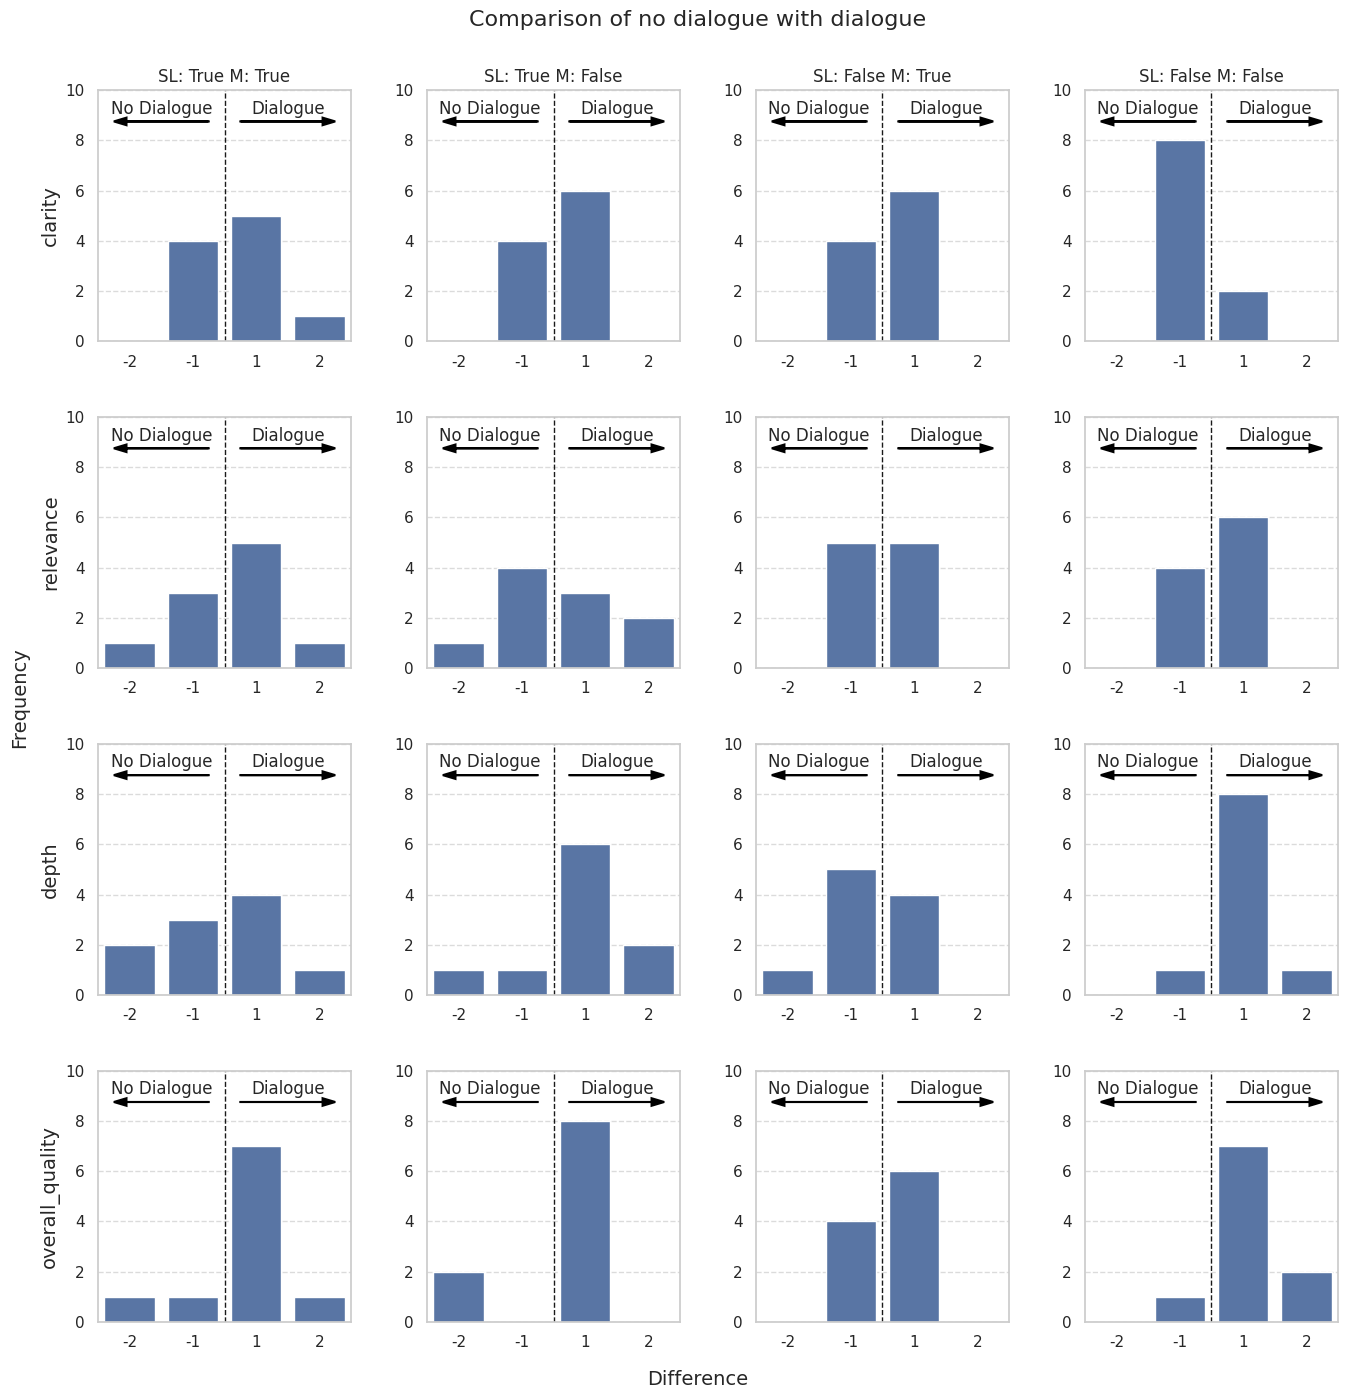

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def draw_arrow(ax, start_x, end_x, y, text):
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin

    dynamic_head_width = yrange * 0.03

    text_x_no_dialogue = (start_x + end_x) / 2

    ax.arrow(start_x, y, (end_x - start_x), 0,
             head_width=dynamic_head_width,
             head_length=0.2,
             fc='black', ec='black', lw=1.5,
             length_includes_head=True)

    ax.text(text_x_no_dialogue,
            y + 0.015 * yrange, text, ha='center', va='bottom')


sns.set_theme(style="whitegrid")

with open('noneVSfree.csv', 'r') as file:
    data = pd.read_csv(file)

    fig, axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, c in enumerate(data['criteria'].unique()):
        fig.suptitle(
            f"Comparison of no dialogue with dialogue", fontsize=16, y=0.93)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        if i == 0:
            fig.text(0.5, fig.subplotpars.bottom - 0.03,
                     "Difference", ha='center', va='top', fontsize=14)
            fig.text(0.07, 0.5, "Frequency", va='center',
                     rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for j, comb in enumerate(combinations):
            student_level = comb[0]
            materials = comb[1]

            # Filter the data for the current criteria
            subset = data[data['criteria'] == c]

            # Filter the data for the current combination
            subset = subset[subset['student_level'] == student_level]
            subset = subset[subset['materials'] == materials]

            difference = subset['difference'].value_counts()

            # Row for each criteria
            # Column for each combination
            ax = axs[i, j]

            sns.barplot(
                x=difference.index,
                y=difference.values,
                ax=ax,
                order=[-2, -1, 1, 2],
            )

            ax.set_xlabel('')
            ax.set_ylabel('')

            # To only the first row add the title
            if i == 0:
                ax.set_title(
                    f"SL: {student_level} M: {materials}")

            # To the first column add the criteria
            if j == 0:
                ax.set_ylabel(c, fontsize=14)

            # Ensure correct labels to values
            ax.set_xlim(-0.5, 3.5)
            ax.set_xticks([0, 1, 2, 3])
            ax.set_xticklabels(['-2', '-1', '1', '2'])

            ax.set_yticks(range(0, 11, 2))
            ax.set_ylim(0, 10)

            ax.axvline(x=1.5, color='k', linestyle='--', linewidth=1)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Draw arrows to indicate the direction of the difference
            arrow_y = 8.75
            draw_arrow(ax, 1.25, -0.25, arrow_y, 'No Dialogue')
            draw_arrow(ax, 1.75, 3.25, arrow_y, 'Dialogue')

    # plt.savefig('Images/noneVSfree.png', dpi=300, bbox_inches='tight')
    plt.show()

In [60]:
# Print the average amount of iterations used by the dynamic dialogue
with open('noneVSfree.csv', 'r') as file:
    data = pd.read_csv(file)

    # Use only one criteria as it is irelevant
    data = data[data['criteria'] == 'clarity']

    # For each combination of student level and materials, calculate the average iterations
    combinations = [[True, True], [True, False],
                    [False, True], [False, False]]

    print("Average iterations for each combination of student level and materials:")
    for comb in combinations:
        student_level = comb[0]
        materials = comb[1]

        # Filter the data for the current combination
        subset = data[data['student_level'] == student_level]
        subset = subset[subset['materials'] == materials]

        print(f"SL: {student_level}, M: {materials}:")
        values = subset['iterations'].value_counts()

        for i in range(len(values)):
            print(f"  {values.index[i]}: {values.values[i]}")

        # Calculate the average iterations
        avg_iterations = subset['iterations'].mean()
        print(f"Avg: {avg_iterations:.2f}")

Average iterations for each combination of student level and materials:
SL: True, M: True:
  2: 9
  3: 1
Avg: 2.10
SL: True, M: False:
  2: 7
  3: 2
  4: 1
Avg: 2.40
SL: False, M: True:
  2: 9
  3: 1
Avg: 2.10
SL: False, M: False:
  2: 7
  3: 2
  4: 1
Avg: 2.40
